In [5]:
# import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

import os
import utils
import seaborn as sns 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore")

# Prepare datasets

In [6]:
# save the dataset in the directory data/ETF/ARMA
for ETF in ["SPY", "DIA", "QQQ"]:
    os.makedirs(os.path.join("data", ETF, "ARMA"), exist_ok=True)
    
    df = pd.read_csv("data/" + ETF + ".csv")
    df['Return'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(periods=1))
    
    # set date column as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    Total = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
    Training = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
    Test = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
    Out_of_sample = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

    utils.save_file(Training, os.path.join("data", ETF, "ARMA", "Train.pkl"))
    utils.save_file(Test, os.path.join("data", ETF, "ARMA", "Valid.pkl"))
    utils.save_file(Out_of_sample, os.path.join("data", ETF, "ARMA", "Test.pkl"))
    utils.save_file(Total, os.path.join("data", ETF, "ARMA", "Total.pkl"))

data\SPY\ARMA\Train.pkl saved
data\SPY\ARMA\Valid.pkl saved
data\SPY\ARMA\Test.pkl saved
data\SPY\ARMA\Total.pkl saved
data\DIA\ARMA\Train.pkl saved
data\DIA\ARMA\Valid.pkl saved
data\DIA\ARMA\Test.pkl saved
data\DIA\ARMA\Total.pkl saved
data\QQQ\ARMA\Train.pkl saved
data\QQQ\ARMA\Valid.pkl saved
data\QQQ\ARMA\Test.pkl saved
data\QQQ\ARMA\Total.pkl saved


# Load data

In [4]:
ETF = "SPY"

Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample

# Prepare data

In [5]:
Traindf = Traindf.asfreq('d')
Validdf = Validdf.asfreq('d')
Testdf = Testdf.asfreq('d')

trainTarget = Traindf['Return'].copy()
validTarget = Validdf['Return'].copy()
testTarget = Testdf['Return'].copy()

# Fit the model

In [6]:
model = ARIMA(trainTarget, order=(10,0,10), missing='drop') # fit on the out of sample dataset => testTarget
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Return   No. Observations:                  502
Model:                   ARMA(10, 10)   Log Likelihood                1549.702
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 01 Sep 2020   AIC                          -3055.404
Time:                        18:40:02   BIC                          -2962.594
Sample:                             0   HQIC                         -3018.992
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.963      0.050    5.55e-07       0.001
ar.L1.Return      0.0473      0.158      0.300      0.764      -0.262       0.357
ar.L2.Return     -0.0425      0.192     

# Residual check

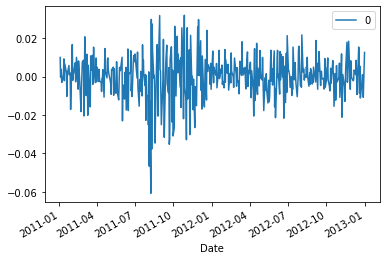

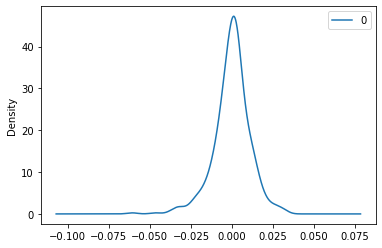

                0
count  502.000000
mean    -0.000059
std      0.011045
min     -0.060766
25%     -0.005199
50%      0.000608
75%      0.005444
max      0.031941


In [7]:
# look at the residual to ensure there are no patterns (that is, look for constant mean and variance)
# normally distributed
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Actual vs Fitted plot

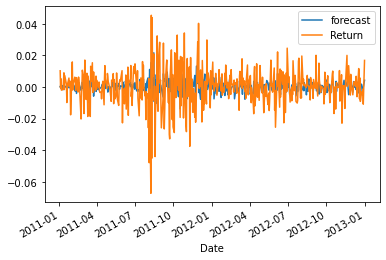

In [8]:
# plot the actuals against the fitted values
model_fit.plot_predict(dynamic=False)
plt.show()

Text(0.5, 1.0, 'SPY - ARMA')

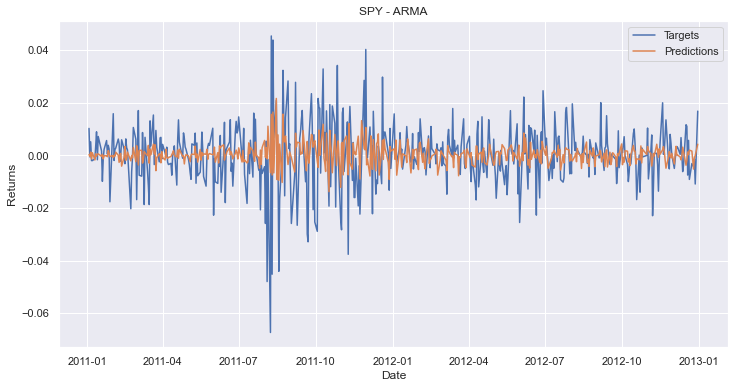

In [9]:
sns.set()
fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=Traindf.index, y='Return', data=Traindf, label="Targets")
sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions")
ax.set_ylabel('Returns')
ax.set_title(ETF + " - ARMA")

# Out of Sample forecast

Text(0, 0.5, 'Returns')

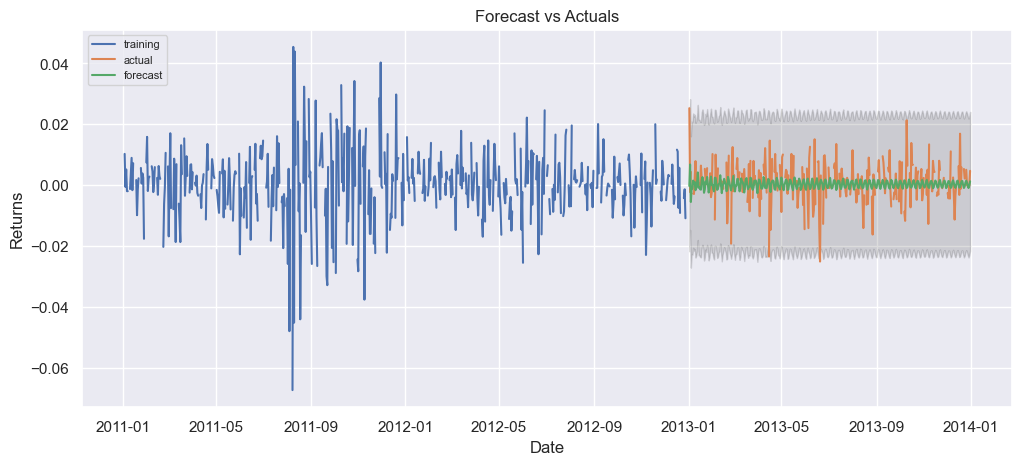

In [10]:
# Forecast on the test
fc, se, conf = model_fit.forecast(len(validTarget), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=validTarget.index)
lower_series = pd.Series(conf[:, 0], index=validTarget.index)
upper_series = pd.Series(conf[:, 1], index=validTarget.index)

# Plot
sns.set()
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainTarget, label='training')
plt.plot(validTarget, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel("Date")
plt.ylabel("Returns")

plt.savefig('table/ARMAForecastVsActual.png' , bbox_inches='tight')

# ARMA with a Rolling Train and Valid dataset over the Out of Sample (Test)

In [80]:
ETF = "DIA"

# load datasets
Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample

# set frequency
Traindf = Traindf.asfreq('d')
Validdf = Validdf.asfreq('d')
Testdf = Testdf.asfreq('d')

# define targets
trainTarget = Traindf['Return'].copy()
validTarget = Validdf['Return'].copy()
testTarget = Testdf['Return'].copy()

# fit on train and valid
trainAndValid = pd.concat([Traindf, Validdf])
trainAndValidTarget = trainAndValid['Return'].copy()

# fit the model
if ETF == "SPY":
    ARIMA_order = (8,0,8)
elif ETF == "DIA":
    ARIMA_order = (10,0,10)
else:
    ARIMA_order = (7,0,7)

model = ARIMA(trainAndValidTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
model_fit = model.fit(disp=0)

ARMA_pred = []
ARMA_pred_index = []
# n = len(testTarget) # too long
n = 5

for k in range(n):
    print("Stage " + str(k) + "/" + str(n))
    
    # add the element to the "known" values
    targetValues = np.concatenate((trainAndValidTarget.values, testTarget[[k]].values))
    targetIndex = np.concatenate((trainAndValidTarget.index, testTarget[[k]].index))   
    trainAndValidTarget = pd.Series(targetValues, index=targetIndex)
        
    if testTarget[[k]].isnull()[0] == True:
        next
    else:
        fc, se, conf = model_fit.forecast(1, alpha=0.05)  # 95% conf

        print(fc)
        
        # adding the prediction to the series of prediction
        ARMA_pred.append(fc[0])
        ARMA_pred_index.append(testTarget[[k]].index)
        
        # refit the model
        model = ARIMA(trainAndValidTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
        model_fit = model.fit(disp=0)

Stage 0/5
[-0.00116576]
Stage 1/5
[-0.00017529]
Stage 2/5
Stage 3/5
Stage 4/5
[0.00155552]


In [81]:
ARMA_pred

[-0.00116576454360969, -0.00017529265931158673, 0.0015555241751664443]

# ARMA fitted on Train + Valid and forecast on Out of Sample

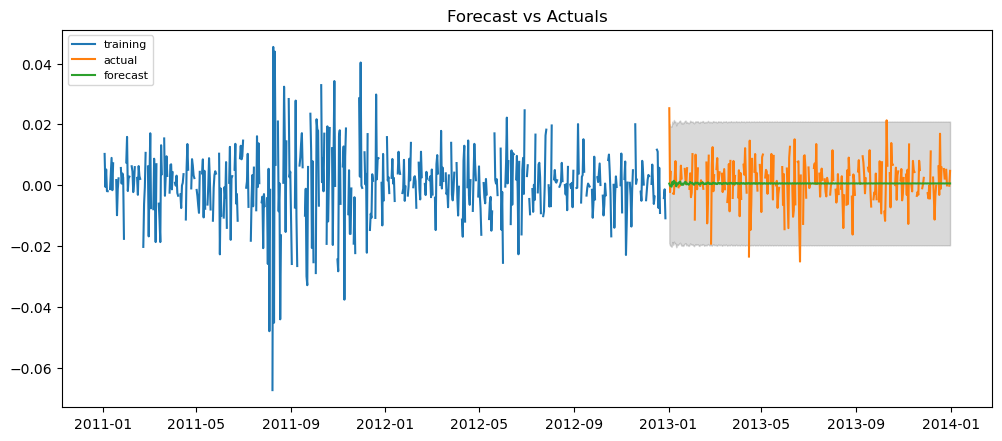

In [83]:
# load data
ETF = "SPY"
#     Totaldf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Total.pkl")
# date column already as index
Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample

# set frequency
Traindf = Traindf.asfreq('d')
Validdf = Validdf.asfreq('d')
Testdf = Testdf.asfreq('d')

# define targets
trainTarget = Traindf['Return'].copy()
validTarget = Validdf['Return'].copy()
testTarget = Testdf['Return'].copy()

trainAndValid = pd.concat([Traindf, Validdf])
trainAndValidTarget = trainAndValid['Return'].copy()

# fit the model
if ETF == "SPY":
    ARIMA_order = (8,0,8)
elif ETF == "DIA":
    ARIMA_order = (10,0,10)
else:
    ARIMA_order = (7,0,7)

model = ARIMA(trainAndValidTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
model_fit = model.fit(disp=0)
    
# Forecast on the test
fc, se, conf = model_fit.forecast(len(validTarget), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=validTarget.index)
lower_series = pd.Series(conf[:, 0], index=validTarget.index)
upper_series = pd.Series(conf[:, 1], index=validTarget.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainTarget, label='training')
plt.plot(validTarget, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# All ETFs : ARMA fitted on Out of Sample

models_norm\SPY\ARMA\Predictions.pkl saved
models_norm\DIA\ARMA\Predictions.pkl saved
models_norm\QQQ\ARMA\Predictions.pkl saved


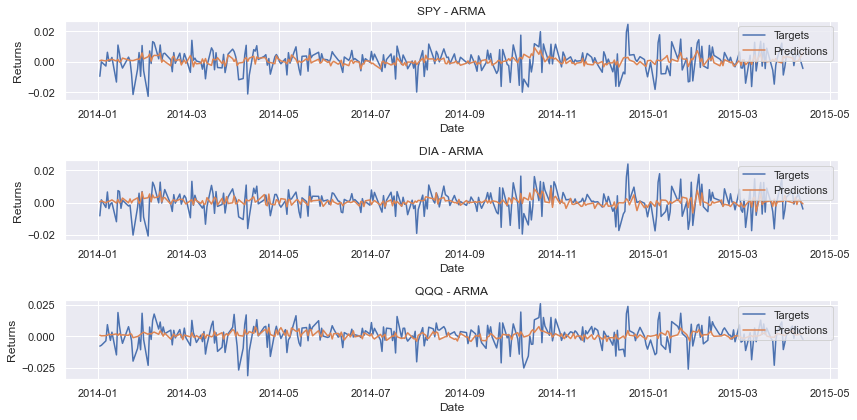

In [7]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))

# load data
for ETF in ["SPY", "DIA", "QQQ"]:
#     Totaldf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Total.pkl")
    # date column already as index
    Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
    Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
    Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample
    
    # set frequency
    Traindf = Traindf.asfreq('d')
    Validdf = Validdf.asfreq('d')
    Testdf = Testdf.asfreq('d')
    
    # define targets
    trainTarget = Traindf['Return'].copy()
    validTarget = Validdf['Return'].copy()
    testTarget = Testdf['Return'].copy()
    
    # fit the model
    if ETF == "SPY":
        ARIMA_order = (8,0,8)
        AX = ax1 # for the plot
    elif ETF == "DIA":
        ARIMA_order = (10,0,10)
        AX = ax2 # for the plot
    else:
        ARIMA_order = (7,0,7)
        AX = ax3 # for the plot
    
    model = ARIMA(testTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
    model_fit = model.fit(disp=0)
    
    fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})
    
    # saving prediction
    os.makedirs(os.path.join("models_norm", ETF, "ARMA"), exist_ok=True)
    utils.save_file(fittedDf, os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
    
    # plot actual vs fitted
#     fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})

#     fig, ax = plt.subplots(figsize = (12,6))
#     fig = sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets")
#     sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions")
#     ax.set_ylabel('Returns')
#     ax.set_title(ETF + " - ARMA")
#     plt.show() 

    sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets", ax=AX)
    sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions", ax=AX)
    AX.set_ylabel('Returns')
    AX.set_title(ETF + " - ARMA")
    AX.legend(loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig('table/ARMAplot.png', bbox_inches='tight')

## Table 4 stats

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    predsDf = pd.read_pickle(os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
    predsDf['Labels'] = testTarget

    labels = np.array(predsDf['Labels'].to_list())
    preds = np.array(predsDf['Predictions'].to_list())
    
    RMSE = np.sqrt(mean_squared_error(labels, preds))
    MAE =  mean_absolute_error(labels, preds)
    MAPE = 100 * utils.mean_absolute_percentage_error(labels, preds)
    THEILU = utils.theilU(labels, preds)
    Table["ARMA"] = [MAE, MAPE, RMSE, THEILU]
    Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)
Table4.set_index(["ETF"], inplace=True)
Table4.to_csv("table/ARMATable4.csv", index=True)

In [9]:
Table4

,Statistic,ARMA
ETF,,
SPY,MAE,0.006489
SPY,MAPE,140.823292
SPY,RMSE,0.008476
SPY,THEIL-U,0.772154
DIA,MAE,0.006398
DIA,MAPE,153.338891
DIA,RMSE,0.008478
DIA,THEIL-U,0.763919
QQQ,MAE,0.006586
